In [1]:
import uproot
import os
import pickle
import numpy as np
import pandas as pd

from HH4b.utils import load_samples, format_columns

import mplhep as hep
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import hist

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

from scipy.stats import norm

# Check mass regression

Compare with legacy
- Check resolution in HH4b
- Check signal and background efficiency

In [2]:
year = "2022EE"

sample_dirs = {
    f"../../../../data/skimmer/24Apr23LegacyLowerThresholds_v12_private_signal/": {
        "hh4b_v12_private": ["GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV"],
        "ttbar_v12_private": ["TTto4Q", "TTtoLNu2Q"],
    },
}

load_columns = [
    ("bbFatJetPNetTXbbLegacy", 2),
    ("bbFatJetPNetMassLegacy", 2),
    ("bbFatJetPNetTXbb", 2),
    ("bbFatJetPNetMass", 2),  
    ("bbFatJetMsd", 2), 
    ("weight", 1),    
    ("trigger_sf", 1),
]

events_dict = {}
for input_dir, samples_dict in sample_dirs.items():
    print(input_dir)
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **load_samples(
            input_dir,
            samples_dict,
            year,
            variations=False,
            columns=format_columns(load_columns),
            reorder_legacy_txbb=True,
        ),
    }

../../../../data/skimmer/24Apr23LegacyLowerThresholds_v12_private_signal/
Loaded GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV: 169191 entries
Loaded TTtoLNu2Q                                         : 1332035 entries
Loaded TTto4Q                                            : 3199197 entries


Load Run 2

In [3]:
year = "2018"
path_to_dir_run2 = f"../../../../data/skimmer/20211209_regression/"
samples_run2 = {
    "hh4b_run2": [
        "GluGluToHHTo4B_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8_1pb_weighted_Testing_BDTs.root",
    ],
    "ttbar_run2": [
        "TTToHadronic_TuneCP5_13TeV-powheg-pythia8-combined_1pb_weighted_Testing_BDTs.root",
        "TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8-combined_1pb_weighted_Testing_BDTs.root",
    ],
}


columns = [
    "run",
    "luminosityBlock",
    "event",
    "fatJet1Pt",
    "fatJet1Eta",
    "fatJet1Phi",
    "fatJet1Mass",
    "fatJet1MassSD",
    "fatJet1MassRegressed",
    "fatJet1PNetXbb",
    "fatJet1PNetQCDb",
    "fatJet1PNetQCDbb",
    "fatJet1PNetQCDothers",
    "fatJet1Tau3OverTau2",
    "fatJet2Pt",
    "fatJet2Eta",
    "fatJet2Phi",
    "fatJet2Mass",
    "fatJet2MassSD",
    "fatJet2PNetXbb",
    "fatJet2PNetQCDb",
    "fatJet2PNetQCDbb",
    "fatJet2PNetQCDothers",
    "fatJet2Tau3OverTau2",
    "fatJet2MassRegressed",
    "fatJet1PtOverMHH",
    "fatJet2PtOverMHH",
    # "fatJet1MassSD_noJMS",
    "ptj2_over_ptj1",
    "hh_pt",
    "hh_eta",
    "hh_mass",
    "met",
    "genHiggs1Pt",
    "genHiggs1Eta",
    "genHiggs1Phi",
    "disc_qcd_and_ttbar_Run2_enhanced_v8p2",
    "xsecWeight",
    "weight",
    "genWeight",
    "triggerEffWeight",
    "puWeight",
]

for key, datasets in samples_run2.items():
    dfs = []
    for dset in datasets:
        df = uproot.open(f"{path_to_dir_run2}/{year}/{dset}:Events").arrays(columns, library="pd")
        # df.rename(columns={"luminosityBlock": "lumi"})
        dfs.append(df)
    events_dict[key] = pd.concat(dfs)

In [4]:
events_dict.keys()

dict_keys(['hh4b_v12_private', 'ttbar_v12_private', 'hh4b_run2', 'ttbar_run2'])

In [14]:
mratio_axis = hist.axis.Regular(
    80, 0, 1.85, name="ratio", label=r"Xbb ordered FatJet - m / m$_{truth}$"
)
xbb_axis = hist.axis.Regular(60, 0, 1, name="xbb", label="Xbb ordered FatJet - PNet Xbb")
mass_axis = hist.axis.Regular(25, 0, 250, name="mass", label="Xbb ordered FatJet - Mass")
mass_fine_axis = hist.axis.Regular(60, 80, 180, name="mass", label="Xbb ordered FatJet - Mass")

massversion_axis = hist.axis.StrCategory([], name="massversion", growth=True)
version_axis = hist.axis.StrCategory([], name="version", growth=True)

h1 = hist.Hist(mass_axis, version_axis, massversion_axis)
h2 = hist.Hist(mass_axis, version_axis, massversion_axis)

h1_fine = hist.Hist(mass_fine_axis, version_axis, massversion_axis)
h2_fine = hist.Hist(mass_fine_axis, version_axis, massversion_axis)

Efficiency Run 2 vs Run 3

In [36]:
gaus_fit = {}
mean_std = {}

for key in ["hh4b_run2", "hh4b_v12_private", "ttbar_run2", "ttbar_v12_private"]:
    print(key)
    events = events_dict[key]
    if "v12" in key:
        xbb1 = events["bbFatJetPNetTXbbLegacy"][0]
        xbb2 = events["bbFatJetPNetTXbbLegacy"][1]
    else:
        xbb1 = events["fatJet1PNetXbb"]
        xbb2 = events["fatJet2PNetXbb"]
    mask_xbb1 = (xbb1 > 0.8)
    events = events[mask_xbb1]

    mask_xbb2 = (xbb2[mask_xbb1] > 0.8)
    # events = events[(xbb1 > 0.8) & (xbb2 > 0.8)]

    if "v12" in key:
        mass1 = events["bbFatJetPNetMass"][0]
        mass2 = events["bbFatJetPNetMass"][1]
        massleg1 = events["bbFatJetPNetMassLegacy"][0]
        massleg2 = events["bbFatJetPNetMassLegacy"][1]
        msd1 = events["bbFatJetMsd"][0]
        msd2 = events["bbFatJetMsd"][1]
        #events["finalWeight2022EE"] = events["finalWeight"] * 26671.7/26337.0
    else:
        massleg1 = events["fatJet1MassRegressed"]
        massleg2 = events["fatJet2MassRegressed"]
        msd1 = events["fatJet1MassSD"]
        msd2 = events["fatJet2MassSD"]
        mass1 = None
        mass2 = None
        if "hh4b" in key:
            events["finalWeight"] = events["xsecWeight"] * events["weight"] *events["puWeight"] * 26337.0
        else:            
            events["finalWeight"] = events["xsecWeight"] * events["genWeight"] *events["puWeight"] * 26337.0

    mass_low = 90
    mass_high = 140

    mask_msd = (msd1 >mass_low) & (msd1 < mass_high) & (msd2 > mass_low) & (msd2 < mass_high)
    mask_leg = (massleg1 > mass_low) & (massleg1 < mass_high) & (massleg2 > mass_low) & (massleg2 < mass_high)

    before = np.sum(events["finalWeight"])
    after_msd = np.sum(events["finalWeight"][mask_msd])
    after_leg = np.sum(events["finalWeight"][mask_leg])

    print(f"Number of events before {before:.2f}")
    print(f"Number of events after [{mass_low}-{mass_high}] SD cut {after_msd:.2f}, {after_msd/before:.3f}")
    print(f"Number of events after [{mass_low}-{mass_high}] Regression Legacy cut {after_leg:.2f}, {after_leg/before:.3f}")

    h1.fill(massleg1, key, "pnet_mass") #, weight=events["finalWeight"])
    h1.fill(msd1, key, "msd") #, weight=events["finalWeight"])
    h2.fill(massleg2, key, "pnet_mass") #, weight=events["finalWeight"])
    h2.fill(msd2, key, "msd") #, weight=events["finalWeight"])

    mass_low_res = 80
    mass_high_res = 180
    h1_fine.fill(massleg1[mask_xbb2], key, "pnet_mass")
    h1_fine.fill(msd1[mask_xbb2], key, "msd")
    h2_fine.fill(massleg2[mask_xbb2], key, "pnet_mass") 
    h2_fine.fill(msd2[mask_xbb2], key, "msd")

    if "hh4b"in key:
        massleg1_val = massleg1[mask_xbb2 & (massleg1>mass_low_res) & (massleg1<mass_high_res)]
        massleg2_val = massleg2[mask_xbb2 & (massleg2>mass_low_res) & (massleg2<mass_high_res)]
        msd1_val = msd1[mask_xbb2 & (msd1>mass_low_res) & (msd1<mass_high_res)]
        msd2_val = msd2[mask_xbb2 & (msd2>mass_low_res) & (msd2<mass_high_res)]
        gaus_fit = {
            **gaus_fit,
            key: {
                "pnet_mass_1": norm.fit(massleg1_val),
                "pnet_mass_2": norm.fit(massleg2_val),
                "msd_1": norm.fit(msd1_val),
                "msd_2": norm.fit(msd2_val),
            }       
        }
        mean_std = {
            **mean_std,
            key: {
                "pnet_mass_1": [np.mean(massleg1_val), np.std(massleg1_val)],
                "pnet_mass_2": [np.mean(massleg2_val), np.std(massleg2_val)],
                "msd_1": [np.mean(msd1_val), np.std(msd1_val)],
                "msd_2": [np.mean(msd2_val), np.std(msd2_val)],
            }       
        }


    if mass1 is not None:
        mask_mass = (mass1 > mass_low) & (mass1 < mass_high) & (mass2 > mass_low) & (mass2 < mass_high)
        after = np.sum(events["finalWeight"][mask_mass])
        print(f"Number of events after [{mass_low}-{mass_high}] Regression cut {after:.2f} {after/before:.3f}")

        h1.fill(mass1, key, "pnet_mass_v12") #, weight=events["finalWeight"])
        h2.fill(mass2, key, "pnet_mass_v12") #, weight=events["finalWeight"])

        h1_fine.fill(mass1[mask_xbb2], key, "pnet_mass_v12")
        h2_fine.fill(mass2[mask_xbb2], key, "pnet_mass_v12")

        if "hh4b"in key:
            if key in gaus_fit:
                mass1_val = mass1[mask_xbb2 & (mass1>mass_low_res) & (mass1<mass_high_res)]
                mass2_val = mass2[mask_xbb2 & (mass2>mass_low_res) & (mass2<mass_high_res)]
                gaus_fit[key] = {
                    **gaus_fit[key],
                    "pnet_mass_v12_1": norm.fit(mass1_val),
                    "pnet_mass_v12_2": norm.fit(mass2_val),
                }   
                mean_std[key] = {
                    **mean_std[key],
                    "pnet_mass_v12_1": [np.mean(mass1_val), np.std(mass1_val)],
                    "pnet_mass_v12_2": [np.mean(mass2_val), np.std(mass2_val)],
                }   


hh4b_run2
Number of events before 5.63
Number of events after [90-140] SD cut 2.37, 0.422
Number of events after [90-140] Regression Legacy cut 2.77, 0.493
hh4b_v12_private
Number of events before 6.02
Number of events after [90-140] SD cut 2.58, 0.428
Number of events after [90-140] Regression Legacy cut 2.80, 0.465
Number of events after [90-140] Regression cut 2.10 0.348
ttbar_run2
Number of events before 76972.70
Number of events after [90-140] SD cut 12778.94, 0.166
Number of events after [90-140] Regression Legacy cut 14859.17, 0.193
ttbar_v12_private
Number of events before 116500.10
Number of events after [90-140] SD cut 18888.01, 0.162
Number of events after [90-140] Regression Legacy cut 20823.81, 0.179
Number of events after [90-140] Regression cut 18591.68 0.160


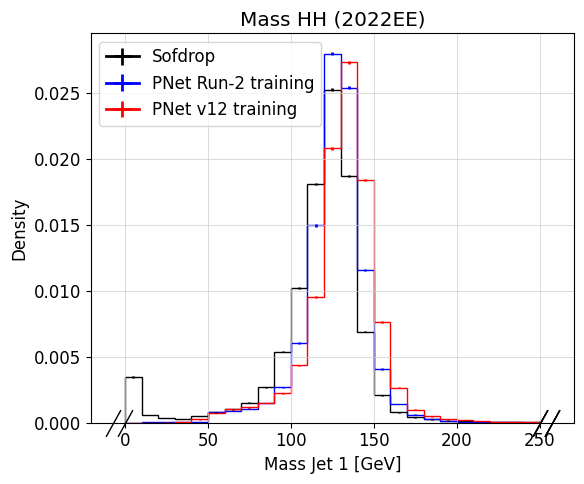

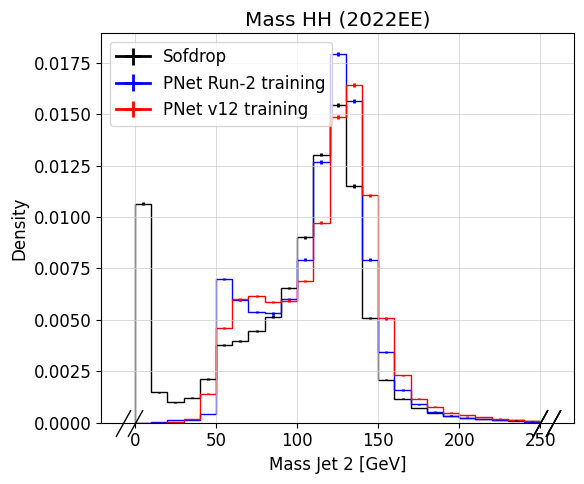

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h1[{"massversion": "msd", "version": "hh4b_v12_private"}], ax=ax, label=f"Sofdrop", color="k", density=True)
hep.histplot(
    h1[{"massversion": "pnet_mass", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet Run-2 training", color="b", density=True
)
hep.histplot(
    h1[{"massversion": "pnet_mass_v12", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet v12 training", color="r", density=True
)
ax.legend()
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 1 [GeV]")
ax.set_title("Mass HH (2022EE)")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h2[{"massversion": "msd", "version": "hh4b_v12_private"}], ax=ax, label=f"Sofdrop", color="k", density=True)
hep.histplot(
    h2[{"massversion": "pnet_mass", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet Run-2 training", color="b", density=True
)
hep.histplot(
    h2[{"massversion": "pnet_mass_v12", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet v12 training", color="r", density=True
)
ax.legend()
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 2 [GeV]")
ax.set_title("Mass HH (2022EE)")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()

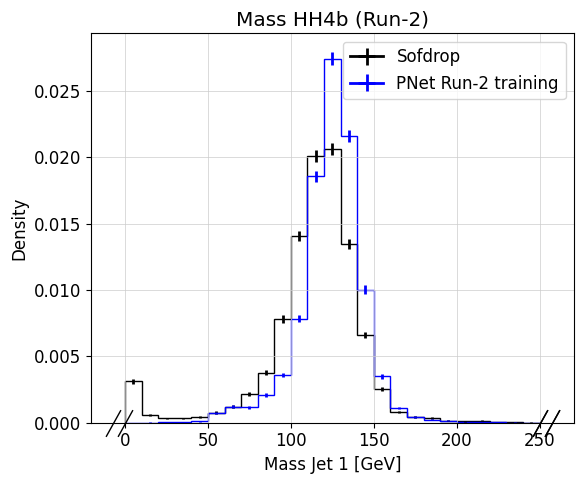

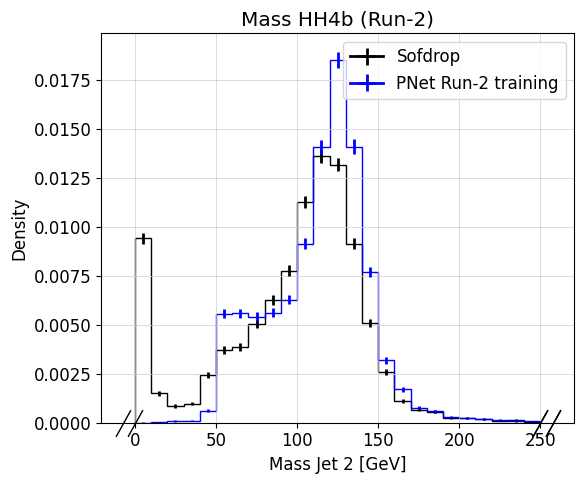

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h1[{"massversion": "msd", "version": "hh4b_run2"}], ax=ax, label=f"Sofdrop", color="k", density=True)
hep.histplot(
    h1[{"massversion": "pnet_mass", "version": "hh4b_run2"}], ax=ax, label=f"PNet Run-2 training", color="b", density=True
)
ax.legend()
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 1 [GeV]")
ax.set_title("Mass HH4b (Run-2)")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h2[{"massversion": "msd", "version": "hh4b_run2"}], ax=ax, label=f"Sofdrop", color="k", density=True)
hep.histplot(
    h2[{"massversion": "pnet_mass", "version": "hh4b_run2"}], ax=ax, label=f"PNet Run-2 training", color="b", density=True
)
ax.legend()
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 2 [GeV]")
ax.set_title("Mass HH4b (Run-2)")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()

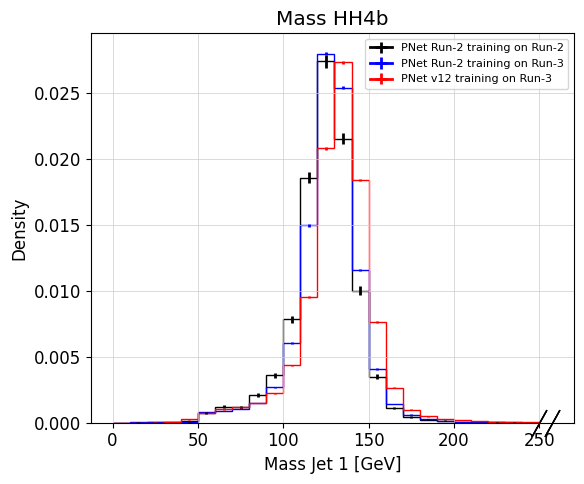

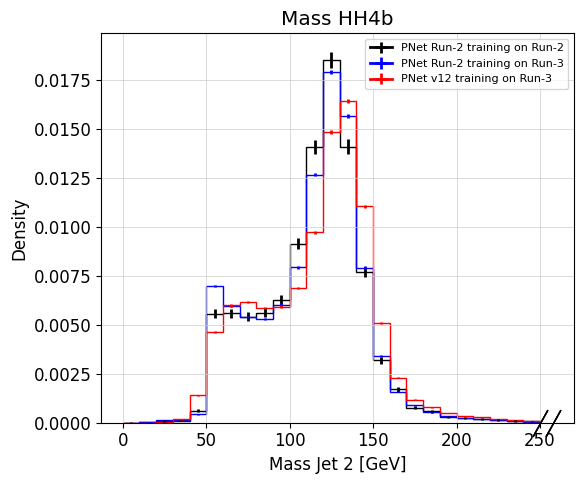

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h1[{"massversion": "pnet_mass", "version": "hh4b_run2"}], ax=ax, label=f"PNet Run-2 training on Run-2", color="k", density=True)
hep.histplot(
    h1[{"massversion": "pnet_mass", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet Run-2 training on Run-3", color="b", density=True
)
hep.histplot(
    h1[{"massversion": "pnet_mass_v12", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet v12 training on Run-3", color="r", density=True
)
ax.legend(fontsize=8)
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 1 [GeV]")
ax.set_title("Mass HH4b")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h2[{"massversion": "pnet_mass", "version": "hh4b_run2"}], ax=ax, label=f"PNet Run-2 training on Run-2", color="k", density=True)
hep.histplot(
    h2[{"massversion": "pnet_mass", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet Run-2 training on Run-3", color="b", density=True
)
hep.histplot(
    h2[{"massversion": "pnet_mass_v12", "version": "hh4b_v12_private"}], ax=ax, label=f"PNet v12 training on Run-3", color="r", density=True
)
ax.legend(fontsize=8)
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 2 [GeV]")
ax.set_title("Mass HH4b")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()

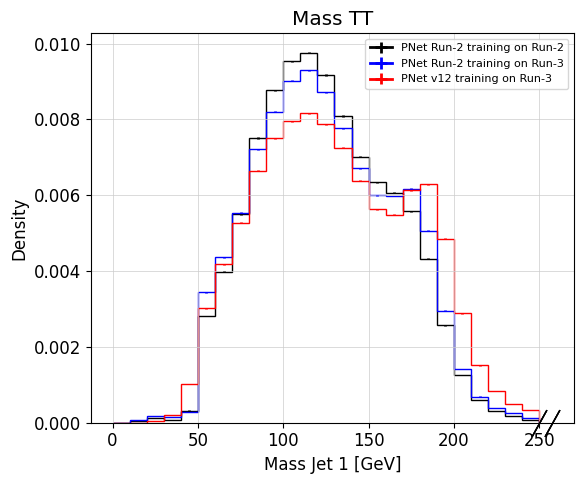

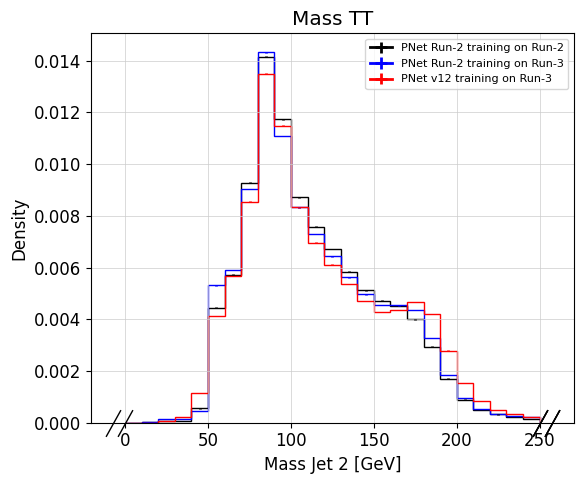

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h1[{"massversion": "pnet_mass", "version": "ttbar_run2"}], ax=ax, label=f"PNet Run-2 training on Run-2", color="k", density=True)
hep.histplot(
    h1[{"massversion": "pnet_mass", "version": "ttbar_v12_private"}], ax=ax, label=f"PNet Run-2 training on Run-3", color="b", density=True
)
hep.histplot(
    h1[{"massversion": "pnet_mass_v12", "version": "ttbar_v12_private"}], ax=ax, label=f"PNet v12 training on Run-3", color="r", density=True
)
ax.legend(fontsize=8)
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 1 [GeV]")
ax.set_title("Mass TT")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
hep.histplot(h2[{"massversion": "pnet_mass", "version": "ttbar_run2"}], ax=ax, label=f"PNet Run-2 training on Run-2", color="k", density=True)
hep.histplot(
    h2[{"massversion": "pnet_mass", "version": "ttbar_v12_private"}], ax=ax, label=f"PNet Run-2 training on Run-3", color="b", density=True
)
hep.histplot(
    h2[{"massversion": "pnet_mass_v12", "version": "ttbar_v12_private"}], ax=ax, label=f"PNet v12 training on Run-3", color="r", density=True
)
ax.legend(fontsize=8)
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 2 [GeV]")
ax.set_title("Mass TT")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
plt.show()
plt.close()


Resolution

In [16]:
gaus_fit

{'hh4b_run2': {'pnet_mass_1': (126.14634, 14.960806),
  'pnet_mass_2': (124.78276, 17.436916),
  'msd_1': (120.15639, 16.908049),
  'msd_2': (119.75386, 18.902365)},
 'hh4b_v12_private': {'pnet_mass_1': (128.36687357940508, 14.41549278443062),
  'pnet_mass_2': (125.75381554605767, 17.41582661410026),
  'msd_1': (122.78716789812923, 15.390457541818419),
  'msd_2': (121.87945125945335, 17.669183740733406),
  'pnet_mass_v12_1': (133.0127533968588, 15.366624846013696),
  'pnet_mass_v12_2': (129.64653559550408, 18.799391526323134)}}

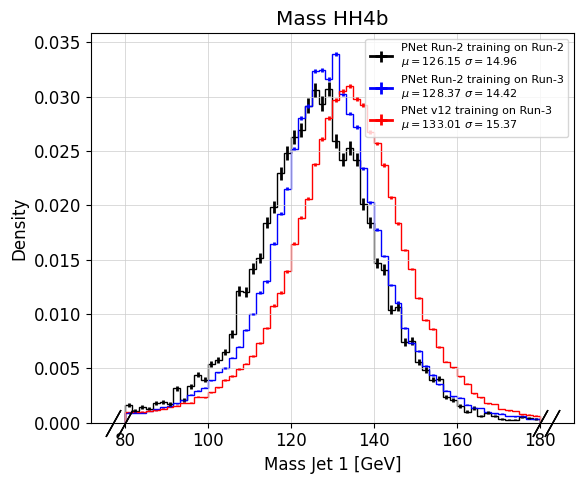

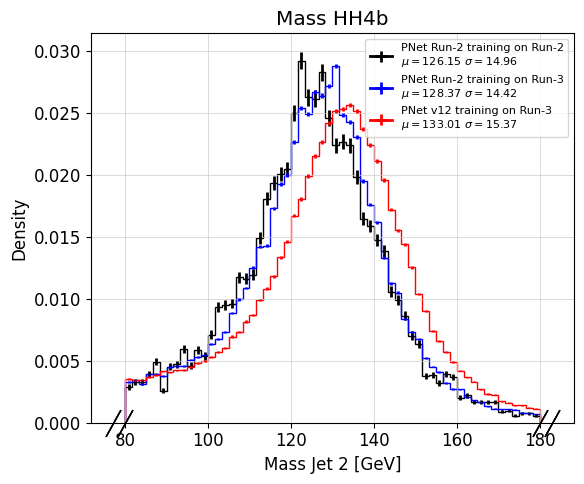

In [37]:
hists = {
    "PNet Run-2 training on Run-2": {"massversion": "pnet_mass", "version": "hh4b_run2", "color": "k"},
    "PNet Run-2 training on Run-3": {"massversion": "pnet_mass", "version": "hh4b_v12_private", "color": "b"},
    "PNet v12 training on Run-3": {"massversion": "pnet_mass_v12", "version": "hh4b_v12_private", "color": "r"},
}

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for hkey, hdict in hists.items():
    # Gaussian fit
    h = h1_fine[{"massversion": hdict["massversion"], "version": hdict["version"]}]
    n, bins = h.to_numpy()
    mu, sigma = gaus_fit[hdict["version"]][f"{hdict['massversion']}_1"]
    y = norm.pdf( bins, mu, sigma) /1.4
    # l = ax.plot(bins, y, linestyle='dashed', linewidth=2, color=hdict["color"])
    mu, sigma = mean_std[hdict["version"]][f"{hdict['massversion']}_1"]
    hep.histplot(h, ax=ax, label=f"{hkey}"+"\n"+r"$\mu=$"+f"{mu:.2f} "+r"$\sigma=$"+f"{sigma:.2f} ", color=hdict["color"], density=True)
ax.legend(fontsize=8)
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 1 [GeV]")
ax.set_title("Mass HH4b")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
fig.savefig("plots/mass_jet1_resolution_pnetRun2Training.png")
plt.show()
plt.close()


fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for hkey, hdict in hists.items():
    # Gaussian fit
    h = h2_fine[{"massversion": hdict["massversion"], "version": hdict["version"]}]
    n, bins = h.to_numpy()
    mu, sigma = gaus_fit[hdict["version"]][f"{hdict['massversion']}_2"]
    y = norm.pdf( bins, mu, sigma) /1.5
    # l = ax.plot(bins, y, linestyle='dashed', linewidth=2, color=hdict["color"])
    mu, sigma = mean_std[hdict["version"]][f"{hdict['massversion']}_1"]
    hep.histplot(h, ax=ax, label=f"{hkey}"+"\n"+r"$\mu=$"+f"{mu:.2f} "+r"$\sigma=$"+f"{sigma:.2f} ", color=hdict["color"], density=True)
ax.legend(fontsize=8)
ax.set_ylabel("Density")
ax.set_xlabel("Mass Jet 2 [GeV]")
ax.set_title("Mass HH4b")
ax.xaxis.grid(True, which="major")
ax.yaxis.grid(True, which="major")

fig.tight_layout()
fig.savefig("plots/mass_jet2_resolution_pnetRun2Training.png")
plt.show()
plt.close()

